In [1]:
%matplotlib inline

import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.utils import load_img, img_to_array 
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

### Selecionando a pasta com as categorias de imagens LOCALMENTE

In [2]:
root = r'C:\Users\Toshiba\Documents\PetImages'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)

['C:\\Users\\Toshiba\\Documents\\PetImages\\Cat', 'C:\\Users\\Toshiba\\Documents\\PetImages\\Dog']


### Selecionando a pasta com as categorias de imagens GOOGLE COLAB

In [5]:
"""
import os
import zipfile

local_zip = '/tmp/kagglecatsanddogs_5340.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

root = '/tmp/PetImages'
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories)
"""

"\nimport os\nimport zipfile\n\nlocal_zip = '/tmp/kagglecatsanddogs_5340.zip'\nzip_ref = zipfile.ZipFile(local_zip, 'r')\nzip_ref.extractall('/tmp')\nzip_ref.close()\n\nroot = '/tmp/PetImages'\ntrain_split, val_split = 0.7, 0.15\n\ncategories = [x[0] for x in os.walk(root) if x[0]][1:]\n\nprint(categories)\n"

In [3]:
# função auxiliar que carrega a imagem e a retorna junto com o vetor de entrada
def get_image(path):
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

### Carregando todas as imagens da pasta root
Ao rodar a célula na primeira vez ocorreu um erro de carregamento de imagem, com isso foi verificado que tanto na pasta cat como na pasta dog haviam arquivos com tamanho zerado, com isso os arquivos foram excluidos para não comprometer o modelo

In [4]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# contando o numero de classes
num_classes = len(categories)

c:\Users\Toshiba\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:845: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [19]:
num_classes

2

### Randomizando a ordem dos dados

In [20]:
random.shuffle(data)

### Criando os dados de treino, validação e teste (70%, 15%, 15%)

In [21]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

### Separando os rotulos

In [ ]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]

### Pré processando os dados tomando cuidado com que sejam float32 e normalizados entre 0 e 1
Ao tentar executar o código após quase 10 minutos de execução o sistema encontra um erro de memória, onde seria necessário 9.81Gb de memoria para poder processar o array, com isso a parte de normalizar será deixada de lado por enquanto, caso no decorrer do código haja algum problema por conta disso irei alocar memoria fisica como memoria virtual para que o processo seja completado.

In [25]:
# normalize data, trecho comentado pois o computador não possui memória suficiente
#x_train = x_train.astype('float32') / 255.
#x_val = x_val.astype('float32') / 255.
#x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(3750, 2)


In [28]:
# sumario
print("Carregadas %d imagens de %d categorias"%(len(data), num_classes))
print("treino / validação / teste: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

Carregadas 24998 imagens de 2 categorias
treino / validação / teste: 17498, 3750, 3750
training data shape:  (17498, 224, 224, 3)
training labels shape:  (17498, 2)


### Plotando algumas imagens de amostra

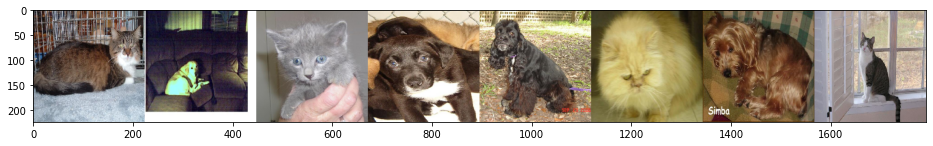

In [30]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

## Criação de rede neural
### Algoritmo utilizado = AdaDelta

In [31]:
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                   

In [32]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
137/137 [==============================] - 601s 4s/step - loss: 1.7139 - accuracy: 0.5686 - val_loss: 0.6518 - val_accuracy: 0.5832
Epoch 2/10
137/137 [==============================] - 600s 4s/step - loss: 0.6404 - accuracy: 0.6169 - val_loss: 0.6127 - val_accuracy: 0.6576
Epoch 3/10
137/137 [==============================] - 882s 6s/step - loss: 0.6090 - accuracy: 0.6589 - val_loss: 0.5963 - val_accuracy: 0.6741
Epoch 4/10
137/137 [==============================] - 660s 5s/step - loss: 0.5875 - accuracy: 0.6834 - val_loss: 0.6222 - val_accuracy: 0.6501
Epoch 5/10
137/137 [==============================] - 615s 4s/step - loss: 0.5648 - accuracy: 0.7011 - val_loss: 0.5581 - val_accuracy: 0.7040
Epoch 6/10
137/137 [==============================] - 842s 6s/step - loss: 0.5418 - accuracy: 0.7265 - val_loss: 0.5251 - val_accuracy: 0.7429
Epoch 7/10
137/137 [==============================] - 594s 4s/step - loss: 0.5163 - accuracy: 0.7426 - val_loss: 0.5158 - val_accuracy: 0.7405

### Plot do loss e acurácia

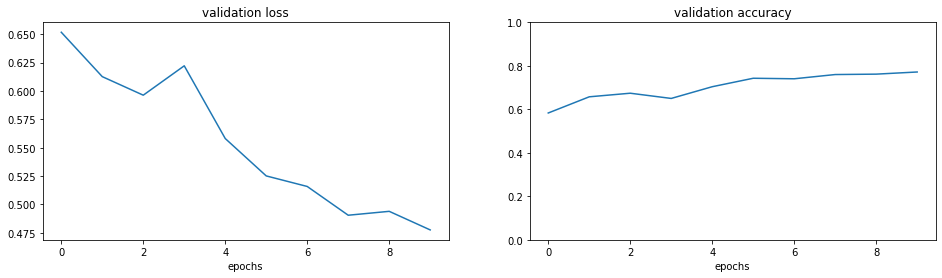

In [37]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [38]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.47310778498649597
Test accuracy: 0.7847999930381775


## Transfer Learning começando com uma network já existente
Vamos carregar a VGG16 do keras

In [39]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 52s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [40]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)

In [41]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [2]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size=128, 
                         epochs=10, 
                         validation_data=(x_val, y_val))

NameError: name 'model_new' is not defined

In [1]:
print('hello world')

hello world
